In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
sif = Location(43.544,-96.73, 'US/Central', 448.086, 'Sioux Falls')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=sif.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=sif.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = sif.get_clearsky(times2009) 
cs_2010and2011 = sif.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-06:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-06:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-06:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-06:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-06:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Sioux_Falls\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1049906, 48)

In [18]:
path = r'.\\data\\Sioux_Falls\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(524982, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(585, 48)

### Merging Clear Sky GHI And the big dataframe

In [20]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1049906, 50)

In [21]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(524982, 50)

In [22]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [23]:
df_train.shape

(1049906, 49)

### Managing missing values

In [24]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
# Dropping rows with two or more -9999.9 values in columns

In [26]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(1048493, 49)

In [27]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(524310, 49)

In [28]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [29]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [30]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [31]:
len(one_miss_train_idx)

6872

In [32]:
df_train.shape

(1048493, 49)

In [33]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [35]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [36]:
len(train)

0

In [37]:
# doing the same thing on test dataset

In [38]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

1576

In [39]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [41]:
len(test)

0

In [42]:
df_train.shape

(1048493, 49)

In [43]:
df_test.shape

(524310, 49)

### Exploratory Data Analysis

In [44]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

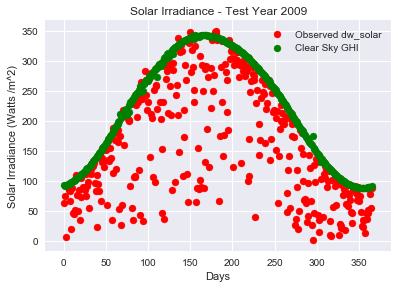

In [45]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


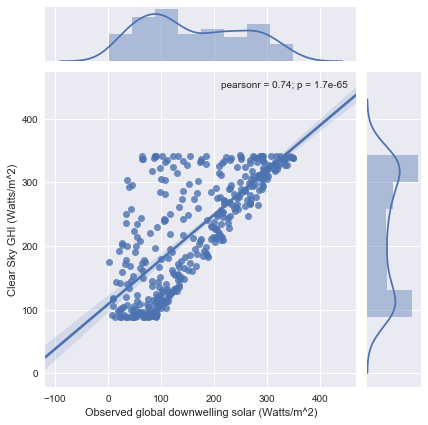

In [46]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure2.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [47]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [48]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [49]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 16815.23562858055
test Kt min: -59.82928662131299
test Kt mean: 2.5854594971725517


train Kt max: 35403.71260380253
train Kt min: -1080.8061639132102
train Kt mean: 2.849421609595172


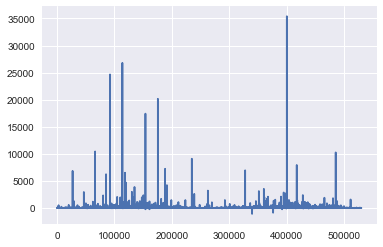

In [50]:
plt.plot(df_train['Kt'])

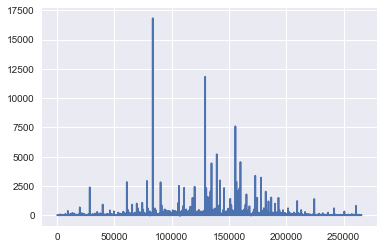

In [51]:
plt.plot(df_test['Kt'])

In [52]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [53]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [54]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [55]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 8.0   147.640000 -3.319298 -0.385965  2.254386  0.217544   
                 9.0   137.909167 -3.186667 -0.033333  1.803333  0.180000   
                 10.0  127.232667 -3.213333  0.013333  1.315000  0.186667   
                 11.0  116.433167 -3.265000  0.000000  1.536667  0.241667   
                 12.0  105.860667 -3.126667 -0.001667  1.645000  0.226667   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 8.0   240.949123   257.463158   257.122807  241.624561   
                 9.0   245.716667   258.640000   258.251667  245.268333   
                 10.0  234.545000   258.533333   258.103333  243.210000   
                 11.0  225.940000   258.170000   257.753333  240.096667   
                 12.0  240.656667   258.306667   257.915000  243.390000   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 8.0    255.159649    ...          0.0  -1.271930  -1.271930   
                 9.0    256.210000    ...          0.0  -0.618333  -0.618333   
                 10.0   256.148333    ...          0.0  -8.660000  -8.660000   
                 11.0   255.845000    ...          0.0 -14.153333 -14.153333   
                 12.0   255.910000    ...          0.0  -2.736667  -2.736667   

                            temp         rh   windspd     winddir    pressure  \
year   month day hour                                                           
2010.0 1.0   1.0 8.0  -17.843860  86.363158  3.459649  322.194737  971.714035   
                 9.0  -16.991667  84.353333  3.388333  340.455000  972.018333   
                 10.0 -17.196667  84.298333  3.696667  342.185000  972.093333   
                 11.0 -17.428333  84.266667  3.226667  335.816667  972.341667   
                 12.0 -17.298333  84.818333  3.295000  331.678333  972.923333   

                              ghi        Kt  
year   month day hour                        
2010.0 1.0   1.0 8.0    56.746103 -0.069423  
                 9.0   173.258555 -0.019518  
                 10.0  291.141970 -0.011144  
                 11.0  369.552873 -0.008872  
                 12.0  397.404717 -0.007868  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [56]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [57]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [58]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
7.0,145.536667,-5.036111,-0.005556,1.050000,-1.691667,225.650000,271.297222,270.644444,290.319444,268.880556,...,0.000000,-64.661111,-64.661111,-4.211111,89.900000,3.958333,150.894444,952.938889,38.153234,-0.171464
8.0,140.396000,-4.896667,-0.068333,1.795000,-1.573333,236.036667,270.815000,270.221667,288.866667,268.450000,...,0.000000,-52.828333,-52.828333,-4.593333,91.183333,3.235000,148.135000,952.245000,148.814364,-0.037425
9.0,131.753500,-4.581667,-0.096667,3.088333,-1.426667,247.976667,270.580000,269.986667,288.435000,268.101667,...,0.000000,-40.468333,-40.468333,-4.898333,92.058333,2.476667,131.661667,951.585000,314.244805,-0.015046
10.0,121.700500,-4.665000,-0.340000,3.340000,-1.415000,241.571667,270.898333,270.323333,287.598333,268.296667,...,0.000000,-46.030000,-46.030000,-4.451667,91.293333,2.421667,145.975000,950.940000,454.239484,-0.010324
11.0,111.024500,-4.480000,-0.051667,4.360000,-1.233333,271.590000,271.455000,270.916667,294.383333,268.693333,...,0.000000,-22.785000,-22.785000,-4.213333,91.341667,2.233333,118.871667,950.326667,548.885814,-0.008169
12.0,100.208500,-4.666667,-0.300000,3.253333,-1.396667,240.323333,271.436667,270.723333,287.046667,268.766667,...,0.000000,-46.735000,-46.735000,-4.025000,91.908333,2.181667,99.051667,949.630000,589.040966,-0.007920
13.0,89.412833,6.941667,2.568333,37.210000,9.313333,229.436667,270.868333,270.236667,288.171667,268.686667,...,9.796667,-58.736667,-48.943333,-4.318333,94.170000,3.183333,115.316667,948.886667,571.239451,0.012708
14.0,79.509000,66.015000,14.283333,39.245000,70.763333,269.898333,272.405000,272.001667,301.948333,269.031667,...,61.178333,-32.058333,29.125000,-3.945000,94.998333,2.643333,128.601667,948.573333,497.007676,0.135205
15.0,70.543833,184.720000,39.195000,60.050000,178.240000,284.471667,275.201667,274.968333,316.086667,271.068333,...,160.998333,-31.616667,129.378333,-2.130000,93.173333,2.938333,140.046667,947.636667,373.110606,0.519083


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [59]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [60]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-1)

In [61]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [62]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [63]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-1)

In [64]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [65]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
2.0,18.0,17.0,57.5765,566.591667,116.545,929.813333,71.201667,193.94,271.468333,270.183333,306.486667,266.746667,...,453.206667,-112.551667,340.67,-7.156667,56.335,9.213333,342.223333,957.198333,64.16627,2382.577671


### Normalize train and test dataframe

In [66]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [67]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [68]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [69]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [70]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [71]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [72]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9600, 22)
y1_train shape is (9600,)
X2_test shape is (4500, 22)
y2_test shape is (4500,)


In [73]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [74]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [75]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [76]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [77]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        n_iter += 1  
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
               

Epoch: 1 Iteration: 100. Train_MSE: 0.052252646535634995. Test_MSE: 0.0018477092542767708
Epoch: 2 Iteration: 200. Train_MSE: 0.027763137593865395. Test_MSE: 0.0011385973112716468
Epoch: 3 Iteration: 300. Train_MSE: 0.010347426868975163. Test_MSE: 0.0007095602160455708
Epoch: 4 Iteration: 400. Train_MSE: 0.01433667540550232. Test_MSE: 0.0004574013971920029
Epoch: 5 Iteration: 500. Train_MSE: 0.006544806994497776. Test_MSE: 0.00032817472761559037
Epoch: 6 Iteration: 600. Train_MSE: 0.0038624608423560858. Test_MSE: 0.00027853543742052797
Epoch: 7 Iteration: 700. Train_MSE: 0.0030486576724797487. Test_MSE: 0.0002694218783193861
Epoch: 8 Iteration: 800. Train_MSE: 0.0014516778755933046. Test_MSE: 0.00027403886381348417
Epoch: 9 Iteration: 900. Train_MSE: 0.000693789916113019. Test_MSE: 0.0002794819994955784
Epoch: 10 Iteration: 1000. Train_MSE: 0.0009710873709991574. Test_MSE: 0.00028467685795046554
Epoch: 11 Iteration: 1100. Train_MSE: 0.002551464829593897. Test_MSE: 0.000289764280421301


Epoch: 95 Iteration: 9100. Train_MSE: 0.002063416177406907. Test_MSE: 0.00018111734095469615
Epoch: 96 Iteration: 9200. Train_MSE: 0.0007277397671714425. Test_MSE: 0.0001805410853939828
Epoch: 97 Iteration: 9300. Train_MSE: 0.0005727705429308116. Test_MSE: 0.00018010854222937151
Epoch: 98 Iteration: 9400. Train_MSE: 0.000340766622684896. Test_MSE: 0.00017890032059088588
Epoch: 99 Iteration: 9500. Train_MSE: 0.0002643617335706949. Test_MSE: 0.00017686063541588957
Epoch: 101 Iteration: 9600. Train_MSE: 0.0008220250019803643. Test_MSE: 0.00017650770063344857
Epoch: 102 Iteration: 9700. Train_MSE: 0.00042297347681596875. Test_MSE: 0.00017688909651547447
Epoch: 103 Iteration: 9800. Train_MSE: 0.000779922294896096. Test_MSE: 0.00017577721663710987
Epoch: 104 Iteration: 9900. Train_MSE: 0.009928803890943527. Test_MSE: 0.0001750947170354167
Epoch: 105 Iteration: 10000. Train_MSE: 0.0016444697976112366. Test_MSE: 0.00017422514408063067
Epoch: 106 Iteration: 10100. Train_MSE: 0.00069812854053452

Epoch: 186 Iteration: 17700. Train_MSE: 0.00035868215491063893. Test_MSE: 0.00013464187658743568
Epoch: 187 Iteration: 17800. Train_MSE: 0.0006018590647727251. Test_MSE: 0.00013445547509253382
Epoch: 188 Iteration: 17900. Train_MSE: 0.00016659084940329194. Test_MSE: 0.00013439619000444323
Epoch: 189 Iteration: 18000. Train_MSE: 0.00016110781871248037. Test_MSE: 0.00013304182271406363
Epoch: 190 Iteration: 18100. Train_MSE: 0.00025923395878635347. Test_MSE: 0.0001327455213739952
Epoch: 191 Iteration: 18200. Train_MSE: 0.0004230492631904781. Test_MSE: 0.00013304682440777731
Epoch: 192 Iteration: 18300. Train_MSE: 0.00025587089476175606. Test_MSE: 0.00013283122775006707
Epoch: 193 Iteration: 18400. Train_MSE: 0.00040770231862552464. Test_MSE: 0.00013260342690205
Epoch: 194 Iteration: 18500. Train_MSE: 0.0005416242638602853. Test_MSE: 0.00013195786391030428
Epoch: 195 Iteration: 18600. Train_MSE: 0.0014243349432945251. Test_MSE: 0.00013125312709301364
Epoch: 196 Iteration: 18700. Train_MSE

Epoch: 276 Iteration: 26300. Train_MSE: 0.00023779345792718232. Test_MSE: 0.00011071192570269362
Epoch: 277 Iteration: 26400. Train_MSE: 0.0001588613959029317. Test_MSE: 0.00011087136265319764
Epoch: 278 Iteration: 26500. Train_MSE: 0.00013201562978792936. Test_MSE: 0.00011057572335867511
Epoch: 279 Iteration: 26600. Train_MSE: 0.00010901068162638694. Test_MSE: 0.00010973510133001646
Epoch: 281 Iteration: 26700. Train_MSE: 0.0005392248276621103. Test_MSE: 0.00010965709992145
Epoch: 282 Iteration: 26800. Train_MSE: 0.00011317108146613464. Test_MSE: 0.00010987556712234237
Epoch: 283 Iteration: 26900. Train_MSE: 0.00024032793589867651. Test_MSE: 0.00010936015668787167
Epoch: 284 Iteration: 27000. Train_MSE: 0.009251076728105545. Test_MSE: 0.00010910392635298912
Epoch: 285 Iteration: 27100. Train_MSE: 0.0010842288611456752. Test_MSE: 0.00010885059174066919
Epoch: 286 Iteration: 27200. Train_MSE: 0.00022517639445140958. Test_MSE: 0.00010874636690019984
Epoch: 287 Iteration: 27300. Train_MSE

Epoch: 367 Iteration: 34900. Train_MSE: 0.0003998764732386917. Test_MSE: 9.703123780515246e-05
Epoch: 368 Iteration: 35000. Train_MSE: 9.52219997998327e-05. Test_MSE: 9.715423017485448e-05
Epoch: 369 Iteration: 35100. Train_MSE: 8.408512076130137e-05. Test_MSE: 9.6574880218844e-05
Epoch: 370 Iteration: 35200. Train_MSE: 0.00018759073282126337. Test_MSE: 9.658935462865338e-05
Epoch: 371 Iteration: 35300. Train_MSE: 0.0003214786993339658. Test_MSE: 9.677662794829704e-05
Epoch: 372 Iteration: 35400. Train_MSE: 0.00013112039596308023. Test_MSE: 9.662134836516626e-05
Epoch: 373 Iteration: 35500. Train_MSE: 0.0001941333757713437. Test_MSE: 9.645929354143551e-05
Epoch: 374 Iteration: 35600. Train_MSE: 0.0003874105168506503. Test_MSE: 9.615170340522877e-05
Epoch: 375 Iteration: 35700. Train_MSE: 0.0011636296985670924. Test_MSE: 9.582609111803516e-05
Epoch: 376 Iteration: 35800. Train_MSE: 0.00018624711083248258. Test_MSE: 9.591233823850278e-05
Epoch: 377 Iteration: 35900. Train_MSE: 0.00010842

Epoch: 459 Iteration: 43700. Train_MSE: 7.762752647977322e-05. Test_MSE: 8.854490267727773e-05
Epoch: 461 Iteration: 43800. Train_MSE: 0.00042280505294911563. Test_MSE: 8.855805358338322e-05
Epoch: 462 Iteration: 43900. Train_MSE: 8.569503552280366e-05. Test_MSE: 8.86656952030889e-05
Epoch: 463 Iteration: 44000. Train_MSE: 0.00015807891031727195. Test_MSE: 8.840738374972081e-05
Epoch: 464 Iteration: 44100. Train_MSE: 0.009144093841314316. Test_MSE: 8.826099942571173e-05
Epoch: 465 Iteration: 44200. Train_MSE: 0.001009712927043438. Test_MSE: 8.812142052850001e-05
Epoch: 466 Iteration: 44300. Train_MSE: 0.00016109996067825705. Test_MSE: 8.807695622021246e-05
Epoch: 467 Iteration: 44400. Train_MSE: 0.0003675805637612939. Test_MSE: 8.815703772843086e-05
Epoch: 468 Iteration: 44500. Train_MSE: 8.207270730054006e-05. Test_MSE: 8.82701185297019e-05
Epoch: 469 Iteration: 44600. Train_MSE: 7.483555964427069e-05. Test_MSE: 8.787842330990227e-05
Epoch: 470 Iteration: 44700. Train_MSE: 0.000166647

Epoch: 552 Iteration: 52500. Train_MSE: 0.00011685288336593658. Test_MSE: 8.316508022608605e-05
Epoch: 553 Iteration: 52600. Train_MSE: 0.00015118523151613772. Test_MSE: 8.305955818432571e-05
Epoch: 554 Iteration: 52700. Train_MSE: 0.00036396674113348126. Test_MSE: 8.288788693208951e-05
Epoch: 555 Iteration: 52800. Train_MSE: 0.0011017665965482593. Test_MSE: 8.270368107644238e-05
Epoch: 556 Iteration: 52900. Train_MSE: 0.00015278447244782. Test_MSE: 8.276834581384511e-05
Epoch: 557 Iteration: 53000. Train_MSE: 7.275765528902411e-05. Test_MSE: 8.28909500565372e-05
Epoch: 558 Iteration: 53100. Train_MSE: 0.00010100848885485902. Test_MSE: 8.282155852551875e-05
Epoch: 559 Iteration: 53200. Train_MSE: 7.108172576408833e-05. Test_MSE: 8.254197664979803e-05
Epoch: 561 Iteration: 53300. Train_MSE: 0.00037501577753573656. Test_MSE: 8.256787082313791e-05
Epoch: 562 Iteration: 53400. Train_MSE: 8.112430805340409e-05. Test_MSE: 8.264509657026096e-05
Epoch: 563 Iteration: 53500. Train_MSE: 0.000141

Epoch: 644 Iteration: 61200. Train_MSE: 0.009109865874052048. Test_MSE: 7.904491520160477e-05
Epoch: 645 Iteration: 61300. Train_MSE: 0.0009889655048027635. Test_MSE: 7.895353791154957e-05
Epoch: 646 Iteration: 61400. Train_MSE: 0.00014532601926475763. Test_MSE: 7.892775191966184e-05
Epoch: 647 Iteration: 61500. Train_MSE: 0.000340847996994853. Test_MSE: 7.900152308798479e-05
Epoch: 648 Iteration: 61600. Train_MSE: 7.007241947576404e-05. Test_MSE: 7.908376254343943e-05
Epoch: 649 Iteration: 61700. Train_MSE: 7.01980316080153e-05. Test_MSE: 7.886086061588226e-05
Epoch: 650 Iteration: 61800. Train_MSE: 0.0001404427021043375. Test_MSE: 7.894181848670902e-05
Epoch: 651 Iteration: 61900. Train_MSE: 0.0002495083899702877. Test_MSE: 7.905138229566977e-05
Epoch: 652 Iteration: 62000. Train_MSE: 0.00011419465590734035. Test_MSE: 7.896764787411259e-05
Epoch: 653 Iteration: 62100. Train_MSE: 0.00014286302030086517. Test_MSE: 7.888099977991961e-05
Epoch: 654 Iteration: 62200. Train_MSE: 0.00035836

Epoch: 736 Iteration: 70000. Train_MSE: 0.0001398595341015607. Test_MSE: 7.602180682147188e-05
Epoch: 737 Iteration: 70100. Train_MSE: 5.995349056320265e-05. Test_MSE: 7.610358889046685e-05
Epoch: 738 Iteration: 70200. Train_MSE: 9.612314170226455e-05. Test_MSE: 7.605470708726263e-05
Epoch: 739 Iteration: 70300. Train_MSE: 6.434879469452426e-05. Test_MSE: 7.587539333835416e-05
Epoch: 741 Iteration: 70400. Train_MSE: 0.0003078352892771363. Test_MSE: 7.589785506558868e-05
Epoch: 742 Iteration: 70500. Train_MSE: 7.578476652270183e-05. Test_MSE: 7.593497125898557e-05
Epoch: 743 Iteration: 70600. Train_MSE: 0.00012440468708518893. Test_MSE: 7.581934735652248e-05
Epoch: 744 Iteration: 70700. Train_MSE: 0.009098593145608902. Test_MSE: 7.573752104706235e-05
Epoch: 745 Iteration: 70800. Train_MSE: 0.000983559526503086. Test_MSE: 7.565859652910266e-05
Epoch: 746 Iteration: 70900. Train_MSE: 0.00014137676043901592. Test_MSE: 7.563525709332858e-05
Epoch: 747 Iteration: 71000. Train_MSE: 0.00033307

Epoch: 829 Iteration: 78800. Train_MSE: 6.896227569086477e-05. Test_MSE: 7.33558551756173e-05
Epoch: 830 Iteration: 78900. Train_MSE: 0.00012205578968860209. Test_MSE: 7.342983111360843e-05
Epoch: 831 Iteration: 79000. Train_MSE: 0.00021630871924571693. Test_MSE: 7.351100679753208e-05
Epoch: 832 Iteration: 79100. Train_MSE: 0.00011031425674445927. Test_MSE: 7.344388260729296e-05
Epoch: 833 Iteration: 79200. Train_MSE: 0.0001353980478597805. Test_MSE: 7.337705336429231e-05
Epoch: 834 Iteration: 79300. Train_MSE: 0.0003512359398882836. Test_MSE: 7.32806100001162e-05
Epoch: 835 Iteration: 79400. Train_MSE: 0.001068870653398335. Test_MSE: 7.317644801567915e-05
Epoch: 836 Iteration: 79500. Train_MSE: 0.00013546527770813555. Test_MSE: 7.321452199453848e-05
Epoch: 837 Iteration: 79600. Train_MSE: 5.630803934764117e-05. Test_MSE: 7.328407469019187e-05
Epoch: 838 Iteration: 79700. Train_MSE: 9.378204413224012e-05. Test_MSE: 7.324126910670322e-05
Epoch: 839 Iteration: 79800. Train_MSE: 6.1708291

Epoch: 922 Iteration: 87600. Train_MSE: 7.113027095329016e-05. Test_MSE: 7.121763699067834e-05
Epoch: 923 Iteration: 87700. Train_MSE: 0.00011497240484459326. Test_MSE: 7.113471525335151e-05
Epoch: 924 Iteration: 87800. Train_MSE: 0.009083273820579052. Test_MSE: 7.106984174915839e-05
Epoch: 925 Iteration: 87900. Train_MSE: 0.0009780535474419594. Test_MSE: 7.100671820735474e-05
Epoch: 926 Iteration: 88000. Train_MSE: 0.00013701344141736627. Test_MSE: 7.098856774134506e-05
Epoch: 927 Iteration: 88100. Train_MSE: 0.00032401448697783053. Test_MSE: 7.104393870306594e-05
Epoch: 928 Iteration: 88200. Train_MSE: 6.214267341420054e-05. Test_MSE: 7.109184152317436e-05
Epoch: 929 Iteration: 88300. Train_MSE: 6.86475686961785e-05. Test_MSE: 7.095992481460563e-05
Epoch: 930 Iteration: 88400. Train_MSE: 0.00011391657608328387. Test_MSE: 7.103045546263506e-05
Epoch: 931 Iteration: 88500. Train_MSE: 0.0002014867204707116. Test_MSE: 7.110196345053837e-05
Epoch: 932 Iteration: 88600. Train_MSE: 0.000108

41800


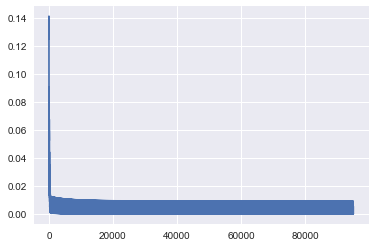

In [78]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


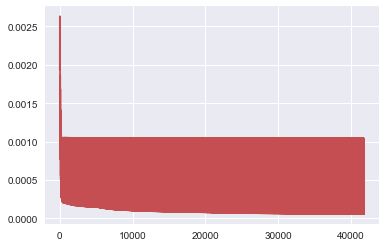

In [79]:
plt.plot(test_loss,'r')

#### Demornamization

In [80]:
rmse = np.sqrt(mse)

In [81]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [82]:
rmse_denorm

26.80224850350189

In [83]:
df_new_test['Kt'].describe()

count    4440.000000
mean        6.944326
std        53.755166
min        -0.127833
25%        -0.002593
50%         0.102688
75%         1.168942
max      2382.577671
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [84]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss, 'iteration':train_iter}, columns=['Train Loss','iteration'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_SiouxFalls_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss, 'iteration':test_iter}, columns=['Test Loss','iteration'])
df_testLoss.to_csv('RNN Paper Results/Exp1_SiouxFalls_TestLoss.csv')